In [32]:
# example taken from http://madhugnadig.com/articles/machine-learning/2017/03/04/implementing-k-means-clustering-from-scratch-in-python.html
# github: https://github.com/madhug-nadig/Machine-Learning-Algorithms-from-Scratch/blob/master/K%20Means%20Clustering.py

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd 
from scipy.interpolate import lagrange

from secrets import ShamirSecretSharing, AdditiveSecretSharing, Vandermonde, P, RandPoly

style.use('ggplot')
%matplotlib inline

In [29]:

def merge(f, g):
    assert len(f) == len(g), "length mismatch!"
    d = np.array([(f[i] - g[i]) ** 2 for i in range(len(f))])
    return np.sum(d)


def reconstruct(shares):
    x = np.arange(1, len(shares) + 1)
    y = shares
    f = lagrange(x, y)
    return f(0)


class NetworkShare:
    def __init__(self, node_id, k, n=2):
        '''
        :param id: node's id
        :param k: number of participants
        :param n: shamir's polynomial degree
        '''
        self.id = node_id
        self.k = k
        self.n = n
        self.shares = dict()

    def _get_share_computations(self, n, t, secrets):
        computations = []
        for secret in secrets:
            shamir = ShamirSecretSharing(n=n, t=t)
            shares = shamir.generate(s=secret)
            computations.append((shamir, shares))
        return computations

    def create_shares(self, data, share_type="f"):
        '''
        :param share_type: the type of shares to create
        :param data: network data
        :return: shares of data
        '''
        # returns shares of data
        computations = self._get_share_computations(n=self.n, t=self.n, secrets=data)
        f = [computations[i][0].poly for i in range(len(data))]
        shares = [[f[i](j) for i in range(self.n)] for j in range(1, self.k + 1)]

        shares = np.array(shares)
        self.shares[share_type] = shares

        return self.get_own_shares(share_type=share_type)

    def get_point(self,extern_data, index):
        return extern_data[index]

    def set_shares(self, shares, share_type):
        self.shares[share_type] = shares

    def merge_shares(self, shares, by=merge, from_type="f", to_type="d"):
        '''
        :param to_type: resulting shares type
        :param from_type: input shares type
        :param by: merging function
        :param shares: shares to merge
        :return: merged shares
        '''
        own_shares = self.get_own_shares(share_type=from_type)
        return self.merge_shares_with(own_shares=own_shares, shares=shares, by=by, to_type=to_type)

    def merge_shares_with(self, own_shares, shares, by=merge, to_type="d"):
        '''
        :param own_shares: node's shares
        :param to_type: resulting shares type
        :param by: merging function
        :param shares: shares to merge
        :return: merged shares
        '''
        self.shares[to_type] = by(own_shares, shares)
        return self.shares[to_type]

    def get_shares_for(self, node_id, share_type):
        return self.get_shares(share_type=share_type)[node_id - 1]

    def get_shares(self, share_type):
        # takes id of node from which we want the shares
        # returns the shares
        #
        # establish connection with node with 'id' using the port and ip from __init__
        # request the shares
        return self.shares.get(share_type)

    def get_own_shares(self, share_type):
        return self.get_shares_for(node_id=self.id, share_type=share_type)


In [30]:
class NetworkNode:
    def __init__(self, port, ip, node_id, k, n=2, is_server=False):
        self.n = n
        self.k = k
        self.node_id = node_id
        self.ip = ip
        self.port = port
        self.shares = dict()
        self.node = NetworkShare(node_id=self.node_id, k=self.k)
        self.is_server = is_server

In [145]:
def secure_euclidean_distance(extern_data, index, centroid):
    n=2
    t=2
    k=3
    alice = NetworkShare(node_id=1, k=k)
    print(f"centroid: {centroid}")
    alice.create_shares(data=centroid)

    bob = NetworkNode(ip="192.168.0.2", port=83, k=3, node_id=2)
    point = bob.node.get_point(extern_data, index)
    bob.node.create_shares(data=point)

    server = NetworkNode(ip="192.168.0.3", port=83, k=3, node_id=3, is_server=True)

    # alice
    alice_received_from_bob = bob.node.get_shares_for(node_id=1, share_type="f")
    alice.merge_shares(shares=alice_received_from_bob, by=merge)

    # bob
    bob_received_from_alice = alice.get_shares_for(node_id=2, share_type="f")
    bob.node.merge_shares(shares=bob_received_from_alice, by=merge)

    # server
    server_received_from_alice = alice.get_shares_for(node_id=3, share_type="f")
    server_received_from_bob = bob.node.get_shares_for(node_id=3, share_type="f")
    server.node.merge_shares_with(own_shares=server_received_from_bob, shares=server_received_from_alice, by=merge)


    #
    # # alice reconstruction
    alice_d = alice.get_shares("d")
    bob_d = bob.node.get_shares("d")
    server_d = server.node.get_shares("d")
    d = np.array([alice_d, bob_d, server_d])


    # output
    dist =  reconstruct(d)
    return np.sqrt(dist)

In [166]:
dist = secure_euclidean_distance(extern_data=np.array([[4,2]]), index=0, centroid=[1,3])

dist


centroid: [1, 3]


3.1622776601683795

In [167]:
def euclidean_distance(X, Y):
    dist = 0
    for i in range(len(X)):
        dist += (X[i] - Y[i]) ** 2
    return np.sqrt(dist)

def norm(X, Y):
    return np.linalg.norm(X-Y)

In [168]:
class KMeans:
    def __init__(self, k=3, secure=False, epsilon=1e-3, max_iter=500):
        self.k = k # number of clusters
        self.epsilon = epsilon # tolerance
        self.classes = {}
        self.max_iter = max_iter # max iterations
        self.centroids = {}
        self.secure = secure
        
    def fit(self, data, data_length, extern_data):
        # shares instead of data

        # initialize centroids
        for i in range(self.k):
            self.centroids[i] = data[i]
        
        # iterative clustering
        for i in range(self.max_iter):
            self.classes = {}
            for i in range(self.k):
                self.classes[i] = []
            # find nearest centroid
            for index in range(data_length):

                # calculate the distance between data points and a center
                if self.secure is True:
                    print(f"centroids: {self.centroids}")
                    distances = [secure_euclidean_distance(
                        extern_data=extern_data, index=index, centroid=self.centroids[c]
                    ) for c in self.centroids]
                else:
                    distances = [euclidean_distance(features, self.centroids[c]) for c in range(len(self.centroids))]

                # assign each data points to the closest center
                classification = np.argmin(distances)
                self.classes[classification].append(index)
                
            previous = dict(self.centroids)


            # classify data points into k classes or clusters
            for classification in self.classes:
                self.centroids[classification] = np.average(self.classes[classification], axis=0)
                
            is_optimal = True
            
            for centroid in self.centroids:
                original_centroid = previous[centroid]
                current_centroid = self.centroids[centroid]
                
                if np.sum((current_centroid  - original_centroid)/original_centroid * 100.0) > self.epsilon:
                    is_optimal = False
                    
            if is_optimal:
                break
              
            
    def pred(self, data):
        # nearest centroid
        distances = [euclidean_distance(data, self.centroids[c]) for c in self.centroids]
        classification = np.argmin(distances)
        return classification
    

In [169]:
df = pd.read_csv("../data/ipl.csv")

In [170]:
df = df[['one', 'two']]

In [171]:
data = df.values
alice_km = KMeans(k=3, secure=True)
bob_km = KMeans(k=3)

In [172]:
D=3
alice_X = data[:D]
bob_X = data[D:]

In [174]:
alice_km.fit(data=alice_X, extern_data=bob_X, data_length=len(bob_X))
km = alice_km

centroids: {0: array([0.22767982, 0.85820415]), 1: array([0.97918822, 0.07715065]), 2: array([0.5045766 , 0.55311441])}
centroid: [0.22767982 0.85820415]
centroid: [0.97918822 0.07715065]
centroid: [0.5045766  0.55311441]
centroids: {0: array([0.22767982, 0.85820415]), 1: array([0.97918822, 0.07715065]), 2: array([0.5045766 , 0.55311441])}
centroid: [0.22767982 0.85820415]
centroid: [0.97918822 0.07715065]
centroid: [0.5045766  0.55311441]
centroids: {0: array([0.22767982, 0.85820415]), 1: array([0.97918822, 0.07715065]), 2: array([0.5045766 , 0.55311441])}
centroid: [0.22767982 0.85820415]
centroid: [0.97918822 0.07715065]
centroid: [0.5045766  0.55311441]
centroids: {0: array([0.22767982, 0.85820415]), 1: array([0.97918822, 0.07715065]), 2: array([0.5045766 , 0.55311441])}
centroid: [0.22767982 0.85820415]
centroid: [0.97918822 0.07715065]
centroid: [0.5045766  0.55311441]
centroids: {0: array([0.22767982, 0.85820415]), 1: array([0.97918822, 0.07715065]), 2: array([0.5045766 , 0.5531

TypeError: 'numpy.float64' object is not iterable

In [144]:
colors = 10*["r", "g", "c", "b", "k"]


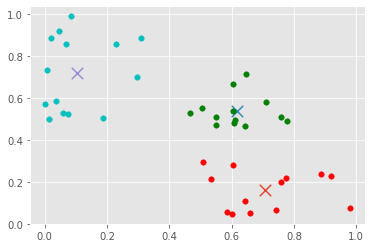

In [16]:
for centroid in km.centroids:
    plt.scatter(km.centroids[centroid][0], km.centroids[centroid][1], s=130, marker="x")
    
for classification in km.classes:
    color = colors[classification]
    for features in km.classes[classification]:
        plt.scatter(features[0], features[1], color=color, s=30)

In [121]:
km.centroids

{0: array([0.60922423, 0.57121492]),
 1: array([0.12406634, 0.74661753]),
 2: array([0.7116907 , 0.16288685])}